In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pandas as pd
from sklearn.pipeline import Pipeline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import Bounds

### Type 1 inverse problem

In [ ]:
# Fisher Traveling wave soludion 
def vec_direction(eps,V):
    A = np.array(([eps*V, 1],[1,V]))/(1-eps*V**2)
    w, v = LA.eig(A)
    return v[:,1]

# u,q system
def du_dx_u_q(U, x, eps, V, gamma):
    F_u = U[0] * (1-U[0]) * (1-U[0]*gamma)
    left_1 = (eps*V*F_u - U[1])/(1 - eps*V**2)
    left_2 = (left_1 + U[1])/(eps*V)
    return [left_1, left_2]

def du_dx_u_q_eps_zero(U, x, eps, V, gamma):
    F_u = U[0] * (1-U[0]) * (1-U[0]*gamma)
    return [-U[1], F_u - V*U[1]]

In [ ]:
def d_dzeta_cent_O6(func, ts):
    delta_z = ts[1] - ts[0]
    f_res = -func[:-6] + 9*func[1:-5] - 45*func[2:-4]\
            + 45*func[4:-2] - 9*func[5:-1] + func[6:]
    return f_res/(60*delta_z)

def specific_value(func, val, modif_r):
    specific_range = np.where(np.logical_and(func>=val-modif_r, func<=val+modif_r))
    return specific_range[0]

def eps_V(u_dz, q, q_dz):
    return (u_dz + q)/q_dz

In [ ]:
def ODE_res(tiny, gam, V, eps, t_end):
    vec_1 = vec_direction(eps, V)
    U0 = [1+tiny*vec_1[0], -tiny*vec_1[1]]
    ts = np.linspace(0, t_end, 10000)
    if eps == 0:
        Us = odeint(du_dx_u_q_eps_zero, U0, ts, args=(eps,  V, gam))
    else:
        Us = odeint(du_dx_u_q, U0, ts, args=(eps,  V, gam))
    u_res = Us[:,0]
    q_res = Us[:,1]
    return [u_res, q_res, ts]

In [ ]:
def gamma_find(gamma,u, u_dz, q_dz):
    F_u = u*(1-u)*(1-u*gamma)
    vel = (q_dz - F_u)/u_dz
    return np.var(vel)
    # return np.abs(np.max(vel) - np.min(vel))

def v_find(gamma,u, u_dz, q_dz):
    F_u = u*(1-u)*(1-u*gamma)
    vel = (q_dz - F_u)/u_dz
    return vel

def para_generate(u, du, q, dq):
    gam_0 = 0
    positive_pos = np.where(dq > 0)[0][-1]

    gam_est = minimize(gamma_find, gam_0, args=(u, du, dq),method='Nelder-Mead', tol=1e-6).x[0]
    v_res = v_find(gam_est, u, du, dq)
    
    eps_pos = eps_V(du[:positive_pos], q[:positive_pos], dq[:positive_pos]) / v_res[:positive_pos]
    eps_neg = eps_V(du[positive_pos+1:], q[positive_pos+1:], dq[positive_pos+1:]) / v_res[positive_pos+1:]

    eps_est = np.mean(np.concatenate((eps_pos, eps_neg)))
    v_est = np.mean(v_res)
    return [gam_est, eps_est, v_est]

In [ ]:
def main_process(tiny, gam, V, eps, t_end):
    u_res, q_res, ts = ODE_res(tiny, gam, V, eps, t_end)
    z_upon = specific_value(u_res, 0.95, 0.003)[0]
    z_low = specific_value(u_res, 0.05, 0.003)[-1]
    u_res_spec = u_res[z_upon:z_low]
    q_res_spec = q_res[z_upon:z_low]
    ts_spec = ts[z_upon+3:z_low-3]

    u_dz = d_dzeta_cent_O6(u_res_spec, ts_spec)
    q_dz = d_dzeta_cent_O6(q_res_spec, ts_spec)
    u_spec = u_res_spec[3:-3]
    q_spec = q_res_spec[3:-3]
    return para_generate(u_spec, u_dz, q_spec, q_dz)

In [ ]:
tiny = 1E-6
gam_res, eps_res, V_res = [], [], []
gam_t, eps_t, V_t = [],[],[]
V_li = [5]
gamma_li = np.linspace(0,0.8, 50)
for V in tqdm(V_li):
    eps_li = [0.02]
    for gam in gamma_li:
        for eps in eps_li:
            gam_est, eps_est, v_est = main_process(tiny, gam, V, eps, 850)
            gam_res.append(gam_est)
            eps_res.append(eps_est)
            V_res.append(v_est)
            gam_t.append(gam)
            eps_t.append(eps)
            V_t.append(V)

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


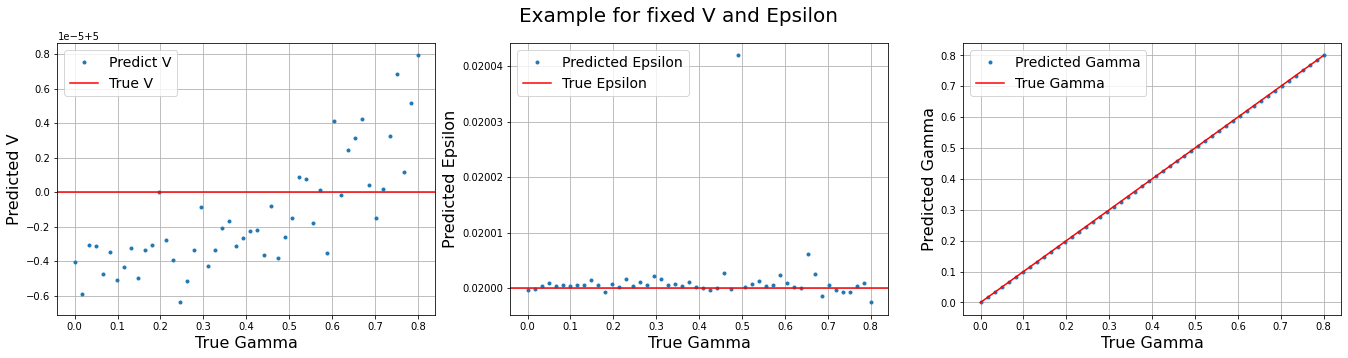

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(23, 5))
fig.suptitle('Example for fixed V and Epsilon', fontsize=20)
ax1.plot(gam_t, V_res,'.', label='Predict V')
ax1.axhline(y=5, color='r', linestyle='-', label='True V')
# ax1.set(xlabel='True Gamma', ylabel='Predict V')
ax1.set_xlabel('True Gamma',fontsize=16)
ax1.set_ylabel('Predicted V', fontsize=16)
ax1.grid()
ax1.legend(loc='upper left', fontsize=14)

ax2.plot(gam_t, eps_res,'.', label='Predicted Epsilon')
ax2.axhline(y=0.02, color='r', linestyle='-', label='True Epsilon')
# ax2.set(xlabel='True Gamma', ylabel='Predicted Epsilon')
ax2.set_xlabel('True Gamma', fontsize=16)
ax2.set_ylabel('Predicted Epsilon',fontsize=16)
ax2.grid()
ax2.legend(loc='upper left', fontsize=14)

ax3.plot(gam_t, gam_res,'.', label='Predicted Gamma')
ax3.plot(gam_t, gam_t,'r', label = 'True Gamma')
# ax3.set(xlabel='True gamma', ylabel='Predict gamma')
ax3.set_ylabel('Predicted Gamma',fontsize=16)
ax3.set_xlabel('True Gamma', fontsize=16)
ax3.grid()
ax3.legend(loc='upper left', fontsize=14)
plt.show()

### Type 2 inverse problem

In [ ]:
# Fisher Traveling wave soludion 
def vec_direction(eps,V):
    A = np.array(([eps*V, 1],[1,V]))/(1-eps*V**2)
    w, v = LA.eig(A)
    return v[:,1]

# cube dudx
def du_dx_cube(U, x,eps,V, gamma):
    # Here U is a vector such that y=U[0] and z=U[1]. This function should return [y', z']
    dF_du = (1-U[0])*(1-U[0]*gamma) - U[0]*(1-U[0]*gamma) - U[0]*(1-U[0])*gamma
    F_u = U[0] * (1-U[0]) * (1-U[0]*gamma)
    return [U[1], ((1- eps*dF_du) * V*U[1] + F_u)/(eps*V**2-1)]


In [ ]:
def d_dzeta_cent_O6(func, ts):
    delta_z = ts[1] - ts[0]
    f_res = -1*func[:-6] + 9*func[1:-5] - 45*func[2:-4] + 0\
            + 45*func[4:-2] - 9*func[5:-1] + 1*func[6:]
    return f_res/(60*delta_z)

def d_ddzeta_cent_O6(func, ts):
    delta_z = ts[1] - ts[0]
    f_res = 2*func[:-6] - 27*func[1:-5] + 270*func[2:-4] - 490*func[3:-3]\
            + 270*func[4:-2] - 27*func[5:-1] + 2*func[6:]
    return f_res/(180*delta_z**2)

In [ ]:
def point_find(ys, u_r):
    min_st = np.abs(ys - u_r).argmin()
    temp = ys.copy()
    temp[min_st] = 1
    min_sec = np.abs(temp - u_r).argmin()
    return np.sort((min_sec, min_st))

def spec_point(ys, tars, u_r, ind_0, ind_1):
    u1 = ys[ind_0]
    u2 = ys[ind_1]
    tar_1 = tars[ind_0]
    tar_2 = tars[ind_1]
    return (u_r - u1) * (tar_1 - tar_2) / (u1 - u2) + tar_1

In [ ]:
def data_V(V_li, p_am, gamma, t_end, eps_amount):
    tiny = 1E-6
    train_raw,col_name = [],[]
    train_div,div_name = [],[]
    target_v,target_eps, target_gamma = [],[],[]
    
    # for eps in eps_li:
    for v in V_li:
        eps_temp = np.linspace(0, 1/v**2,eps_amount+1)[:-1]
        for eps in eps_temp:
            target_v.append(v)
            target_eps.append(eps)
            target_gamma.append(gamma)
            vec_1 = vec_direction(eps,v)
            U0 = [1+tiny*vec_1[0], tiny*vec_1[1]]

            ts = np.linspace(0, t_end, p_am)
            Us = odeint(du_dx_cube, U0, ts, args=(eps, v, gamma))
            ys = Us[:,0]

            u_range = np.linspace(0.05, 0.95, 11)
            u_one,dy_res = [],[]
            start_point = np.where(ys<=0.97)[0][0]
            end_point = np.where(0.03<=ys)[0][-1]
            ys = ys[start_point:end_point]
            ts = ts[start_point:end_point]
            y_dy = d_dzeta_cent_O6(ys, ts)
            start_point_95 = np.where(ys<=0.95)[0][0]
            end_point_05 = np.where(0.05<=ys)[0][-1]

            ys = ys[start_point_95:end_point_05]
            ts = ts[start_point_95:end_point_05]
            y_dy = y_dy[start_point_95-3:end_point_05-3]

            # y_dy = d_dzeta_O6(ys[start_point:end_point], ts)
            for u_r in u_range:
                # Two different graph on this range and add noise!
                spec_u = point_find(ys, u_r)
                spec_ts = spec_point(ys, ts, u_r, spec_u[0], spec_u[1])
                spec_dy = spec_point(ys, y_dy, u_r, spec_u[0], spec_u[1])
                dy_res.append(spec_dy)
                u_one.append(spec_ts)

            train_raw.append(u_one)
            train_div.append(dy_res)
    train_data = np.array(train_raw)
    train_set = train_data[:,:-1] - train_data[:,1:]

    for col in range(1,train_data.shape[1]):
        col_name.append('Dt'+ str(col))

    train_div_set = np.array(train_div)
    for col in u_range:
        col = str(np.round(col, 2))
        col = col.replace(".", "_")
        div_name.append('du_at_' + col)

    data_pd = pd.DataFrame(data=train_set, columns=col_name)
    data_pd['target_V'] = target_v
    data_pd['target_eps'] = target_eps
    data_pd['target_gamma'] = target_gamma
    data_div = pd.DataFrame(data=train_div_set, columns=div_name)
    data_div['target_V'] = target_v
    data_div['target_eps'] = target_eps
    data_div['target_gamma'] = target_gamma
    return [data_pd, data_div]


In [ ]:
classifiers = [
    linear_model.BayesianRidge(),
    linear_model.Ridge(alpha=.1),
    linear_model.Lasso(alpha=0.005,positive=True),
    linear_model.ARDRegression(),
    linear_model.SGDRegressor(),
    linear_model.LinearRegression(),
    linear_model.LinearRegression(positive=True)]
    
def ensumbel(train_fi, target_fi, train_cube, target_cube, classifiers):
    fi_train = []
    cube_pred = []
    for clf in classifiers:
        pipe_c = Pipeline([('transformer', MinMaxScaler()), ('estimator', clf)])
        pipe_c.fit(train_fi, target_fi)
        y_cube = pipe_c.predict(train_cube)
        y_fi = pipe_c.predict(train_fi)
        cube_pred.append(y_cube.tolist())
        fi_train.append(y_fi.tolist())

    fi_train = np.array(fi_train).transpose()
    cube_pred = np.array(cube_pred).transpose()
    lin = linear_model.LinearRegression()
    pipe_v = Pipeline([('transformer', MinMaxScaler()), ('estimator', lin)])
    pipe_v.fit(fi_train, target_fi)
    cube_pred_res = pipe_v.predict(cube_pred)
    return cube_pred_res

In [ ]:
def predict_data(v, gamma, eps, p_am, t_end):
    tiny = 1E-6
    target_set = [v, gamma, eps]

    vec_1 = vec_direction(eps,v)
    U0 = [1+tiny*vec_1[0], tiny*vec_1[1]]

    ts = np.linspace(0, t_end, p_am)
    Us = odeint(du_dx_cube, U0, ts, args=(eps, v, gamma))
    ys = Us[:,0]

    u_range = np.linspace(0.05, 0.95, 11)
    u_one,dy_res = [],[]
    start_point = np.where(ys<=0.97)[0][0]
    end_point = np.where(0.03<=ys)[0][-1]

    ys = ys[start_point:end_point]
    ts = ts[start_point:end_point]
    y_dy = d_dzeta_cent_O6(ys, ts)
    y_ddy = d_ddzeta_cent_O6(ys, ts)

    start_point_95 = np.where(ys<=0.95)[0][0]
    end_point_05 = np.where(0.05<=ys)[0][-1]

    ys = ys[start_point_95:end_point_05]
    ts = ts[start_point_95:end_point_05]
    y_dy = y_dy[start_point_95-3:end_point_05-3]
    y_ddy = y_ddy[start_point_95-3:end_point_05-3]

    for u_r in u_range:
        # Two different graph on this range and add noise!
        spec_u = point_find(ys, u_r)
        spec_ts = spec_point(ys, ts, u_r, spec_u[0], spec_u[1])
        spec_dy = spec_point(ys, y_dy, u_r, spec_u[0], spec_u[1])

        u_one.append(spec_ts)
        dy_res.append(spec_dy)
        
    u_data = np.array(u_one)
    u_data = u_data[:-1] - u_data[1:] 
    div_data = np.array(dy_res)

    start_point_6 = np.where(np.logical_and(ys>=2/3-0.005, ys<=2/3+0.005))[0][0]
    end_point_6 = np.where(np.logical_and(ys>=2/3-0.005, ys<=2/3+0.005))[0][-1]
    index_6 = np.linspace(start_point_6, end_point_6, end_point_6 - start_point_6 +1).astype(int)
    ys = np.delete(ys, index_6)
    ts = np.delete(ts, index_6)
    y_dy = np.delete(y_dy, index_6)
    y_ddy = np.delete(y_ddy, index_6)

    all_col = []
    for col in range(1,u_data.shape[0]+1):
        all_col.append('Dt'+ str(col))
    # for col in u_range:
    #     col = str(np.round(col, 2))
    #     col = col.replace(".", "_")
    #     all_col.append('du_at_' + col)
    return [pd.DataFrame(u_data.reshape(1,-1), columns=all_col),
            ts, ys , y_dy , y_ddy , target_set]


In [ ]:
# Type 2 inverse problem optimize solver
def a_fun(v, u, u_dz, u_ddz):
    left_up = (u - u**2) * (v*u_ddz + u_dz - 2*u_dz*u)
    left_down = u_dz * (3*u - 2)
    right = u_ddz + u - u**2 + v*u_dz
    return left_up/left_down + right

def b_fun(v, u, u_dz, u_ddz):
    return u * (u - u**2)

def c_fun(v, u, u_dz, u_ddz):
    return v * u_dz * u * (3*u - 2)

def d_fun(v, u, u_dz, u_ddz):
    upon = v*u_ddz + u_dz - 2*u_dz*u
    down = u_dz*u * (3*u - 2)
    return -upon/down

def c_over_b_eps(v, u, u_dz):
    upon = u_dz * u * (3*u-2)/v
    down = u * (u - u_dz*u_dz)
    return upon/down

def comb_gamma(var, u, du, ddu):
    v, eps = var
    a_res = a_fun(v, u, du, ddu)
    b_res = b_fun(v, u, du, ddu)
    c_res = c_fun(v, u, du, ddu)
    d_res = d_fun(v, u, du, ddu)

    g_eps = a_res/(b_res + c_res*eps) + d_res
    return np.var(g_eps)

def c_g(v, eps, u, du, ddu):
    a_res = a_fun(v, u, du, ddu)
    b_res = b_fun(v, u, du, ddu)
    c_res = c_fun(v, u, du, ddu)
    d_res = d_fun(v, u, du, ddu)

    g_eps = a_res/(b_res + c_res*eps) + d_res
    return g_eps

In [ ]:
def parameter_est(v_est, u, du, ddu):
    # bounds = Bounds([v_est-0.1 , 0],[v_est+0.1 , 1/v_est**2])
    bounds = Bounds([2 , 0],[np.inf , 0.25])
    var0 = [2 if v_est < 2 else v_est, 0]
    v,eps = minimize(comb_gamma, var0, args=(u, du, ddu),
                      method='CG', tol=1e-6,
                      bounds = bounds).x
    v = 2 if v<2 else v
    eps = 0 if eps<0 else eps
    gam_res = c_g(v, eps, u, du, ddu)
    gam = np.mean(gam_res)
    return [v, eps, gam]

In [ ]:
def true_test_gen(v_list, gamma_list, eps_amount):
    test_set = []
    v_ensumble_est = []
    # v_list = np.linspace(2,10, 20)
    # gamma_list = np.linspace(0, 0.5,10)
    true_data, est_data = [],[]
    for v in tqdm(v_list):
        eps_list = np.linspace(0, 1/v**2, eps_amount+1)[:-1]
        for gam in gamma_list:
            for eps in eps_list:
                pred_data, ts_r, u_set, du_set, ddu_set,target_set = predict_data(v, gam, eps, 50000,3000)
                train_fi = data_fi.drop(['target_eps','target_V','target_gamma'], axis=1)
                target_fi= data_fi['target_V']
                V_ini = ensumbel(train_fi, target_fi, pred_data, target_set[0], classifiers)[0]
                v_ensumble_est.append(V_ini)
                true_data.append([v, eps, gam])
                res_one = parameter_est(V_ini, u_set, du_set, ddu_set)
                est_data.append(res_one)
    return [true_data, est_data, v_ensumble_est]

In [ ]:
v_li = np.linspace(2,5,25)
eps_amount = 5
data_fi,div_fi = data_V(v_li, 10000 , 0, 1000,eps_amount)
gam = np.linspace(0,0.8, 20)[1:]

for g in tqdm(gam):
  data_fi_temp,div_fi_temp = data_V(v_li, 10000 , g, 1000, eps_amount)
  data_fi = data_fi.append(data_fi_temp)
  div_fi = div_fi.append(div_fi_temp)

100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


In [ ]:
# example that V = 3, Gamma = linspace(0,0.8, 50), Epsilon = 0
true_data, est_data, v_ensu = true_test_gen([3], np.linspace(0, 0.8,50), 1)

true_data = np.asarray(true_data)
est_data = np.asarray(est_data)
v_ensu = np.array(v_ensu)

100%|██████████| 1/1 [00:13<00:00, 13.85s/it]


In [ ]:
v_true = true_data[:,0]
v_est = est_data[:,0]
eps_true = true_data[:,1]
eps_est = est_data[:,1]
gam_true = true_data[:,2]
gam_est = est_data[:,2]

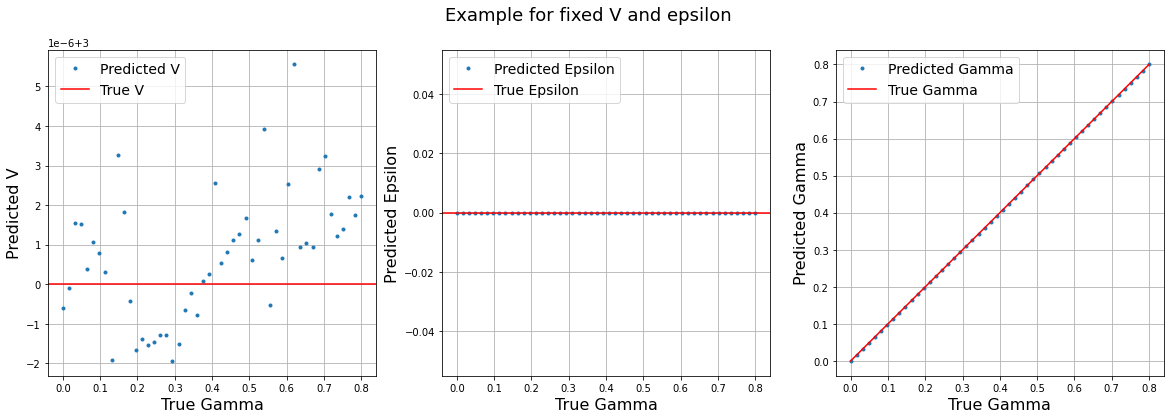

In [ ]:
figure, axis = plt.subplots(1,3,figsize=(20, 6))
figure.suptitle('Example for fixed V and epsilon',fontsize=18)
axis[0].plot(gam_true, v_est,'.', label='Predicted V')
axis[0].axhline(y=3, color='r', linestyle='-', label='True V')
axis[0].set_ylabel('Predicted V',fontsize=16)
axis[0].set_xlabel('True Gamma',fontsize=16)
axis[0].legend(loc='upper left',fontsize=14)
axis[0].grid()

axis[1].plot(gam_true,eps_est,'.', label = 'Predicted Epsilon')
axis[1].axhline(y=0, color='r', linestyle='-', label='True Epsilon')
axis[1].set_ylabel('Predicted Epsilon',fontsize=16)
axis[1].set_xlabel('True Gamma',fontsize=16)
axis[1].legend(loc='upper left',fontsize=14)
axis[1].grid()

axis[2].plot(gam_true,gam_est,'.', label = 'Predicted Gamma')
axis[2].plot(gam_true, gam_true,'r',label='True Gamma')
axis[2].set_ylabel('Predicted Gamma', fontsize=16)
axis[2].set_xlabel('True Gamma', fontsize=16)
axis[2].legend(loc='upper left', fontsize=14)
axis[2].grid()

In [ ]:
# Type 2 inverse problem embedding method
def second_method(V_0, pred_data):
    v_li = np.linspace(V_0-0.1, V_0+0.1, 10)

    temp_fi, temp_div = data_V(v_li, 25000 , 0, 1000, 5)
    gam = np.linspace(0,0.8, 10)[1:]
    for g in gam:
        data_fi_temp,div_temp = data_V(v_li, 25000 , g, 1000, 3)
        temp_fi = temp_fi.append(data_fi_temp)
        temp_div = temp_div.append(div_temp)
    # temp_all = pd.concat([temp_fi.drop(['target_V','target_eps','target_gamma'],axis=1), temp_div],axis=1)

    gamma_train = temp_fi.drop(['target_eps','target_V','target_gamma'], axis=1)
    pred_target = [0]

    target_gamma = temp_fi['target_gamma']
    gam_pred = ensumbel(gamma_train, target_gamma, pred_data, pred_target, classifiers)[0]
    target_gamma = temp_fi['target_eps']
    eps_pred = ensumbel(gamma_train, target_gamma, pred_data, pred_target, classifiers)[0]
    target_gamma = temp_fi['target_V']
    v_pred = ensumbel(gamma_train, target_gamma, pred_data, pred_target, classifiers)[0]
    return [gam_pred, eps_pred, v_pred]

In [ ]:
v_li = np.linspace(2,5,25)
eps_amount = 5
data_fi,div_fi = data_V(v_li, 10000 , 0, 1000,eps_amount)
gam = np.linspace(0,0.8, 20)[1:]

for g in tqdm(gam):
  data_fi_temp,div_fi_temp = data_V(v_li, 10000 , g, 1000, eps_amount)
  data_fi = data_fi.append(data_fi_temp)
  div_fi = div_fi.append(div_fi_temp)
data_all = data_fi

100%|██████████| 19/19 [00:10<00:00,  1.90it/s]


In [ ]:
# General test table
v_li = np.linspace(2,5,10)
eps_amount = 3
test_fi,test_div = data_V(v_li, 25000 , 0, 1000, eps_amount)
gam = np.linspace(0,0.8, 10)[1:]

for g in tqdm(gam):
  data_fi_temp,div_fi_temp = data_V(v_li, 20000 , g, 1000, eps_amount)
  test_fi = test_fi.append(data_fi_temp)
  test_div = test_div.append(div_fi_temp)
test_all = test_fi

100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


In [ ]:
gamma_train = data_all.drop(['target_eps','target_V','target_gamma'], axis=1)
gamma_test_all = test_all.drop(['target_eps','target_V','target_gamma'], axis=1)
pred_target = [0]

In [ ]:
v_res, eps_res, gam_res = [],[],[]

for i in tqdm(range(len(test_all))):
    pred_data = np.array(gamma_test_all.iloc[i,:]).reshape(1,-1)
    target_gamma = data_all['target_V']
    v_pred = ensumbel(gamma_train, target_gamma, pred_data, pred_target, classifiers)[0]
    gam_pred, eps_pred, v_pred = second_method(v_pred, pred_data)
    v_res.append(v_pred)
    gam_res.append(gam_pred)
    eps_res.append(eps_pred)

100%|██████████| 300/300 [11:23<00:00,  2.28s/it]


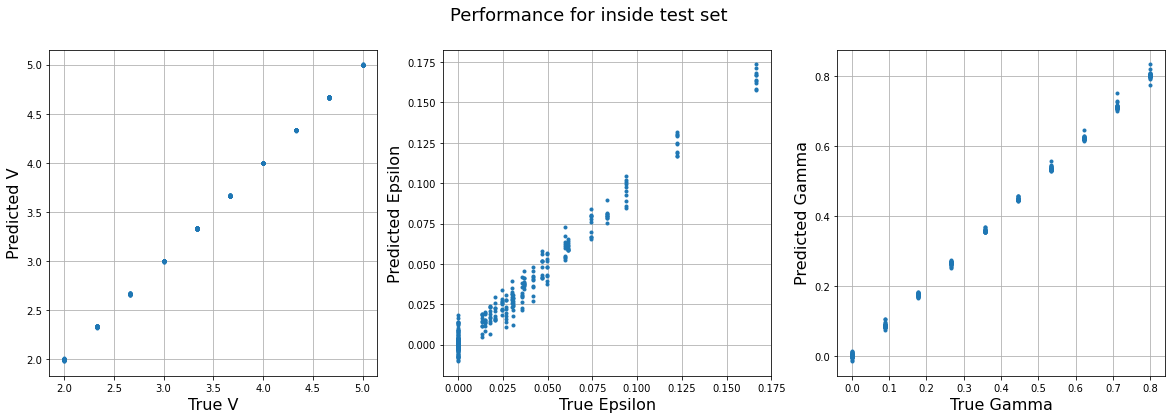

In [ ]:
figure, axis = plt.subplots(1,3,figsize=(20, 6))
figure.suptitle('Performance for inside test set', fontsize=18)
axis[0].plot(np.array(test_all['target_V']), v_res,'.')
axis[0].set_ylabel('Predicted V', fontsize=16)
axis[0].set_xlabel('True V', fontsize=16)
axis[0].grid()

axis[1].plot(np.array(test_all['target_eps']), eps_res,'.')
axis[1].set_ylabel('Predicted Epsilon', fontsize=16)
axis[1].set_xlabel('True Epsilon', fontsize=16)
axis[1].grid()

axis[2].plot(np.array(test_all['target_gamma']), gam_res,'.')
axis[2].set_ylabel('Predicted Gamma', fontsize=16)
axis[2].set_xlabel('True Gamma', fontsize=16)
axis[2].grid()

In [ ]:
v_li = np.linspace(5,10,10)
eps_amount = 3
test_fi,test_div = data_V(v_li, 25000 , 0, 1000, eps_amount)
gam = np.linspace(0,0.8, 10)[1:]

for g in tqdm(gam):
  data_fi_temp,div_fi_temp = data_V(v_li, 20000 , g, 1000, eps_amount)
  test_fi = test_fi.append(data_fi_temp)
  test_div = test_div.append(div_fi_temp)
test_all = test_fi

100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


In [ ]:
gamma_train = data_all.drop(['target_eps','target_V','target_gamma'], axis=1)
gamma_test_all = test_all.drop(['target_eps','target_V','target_gamma'], axis=1)
pred_target = [0]

In [ ]:
v_res, eps_res, gam_res = [],[],[]

for i in tqdm(range(len(test_all))):
    pred_data = np.array(gamma_test_all.iloc[i,:]).reshape(1,-1)
    target_gamma = data_all['target_V']
    v_pred = ensumbel(gamma_train, target_gamma, pred_data, pred_target, classifiers)[0]
    gam_pred, eps_pred, v_pred = second_method(v_pred, pred_data)
    v_res.append(v_pred)
    gam_res.append(gam_pred)
    eps_res.append(eps_pred)

100%|██████████| 300/300 [11:59<00:00,  2.40s/it]


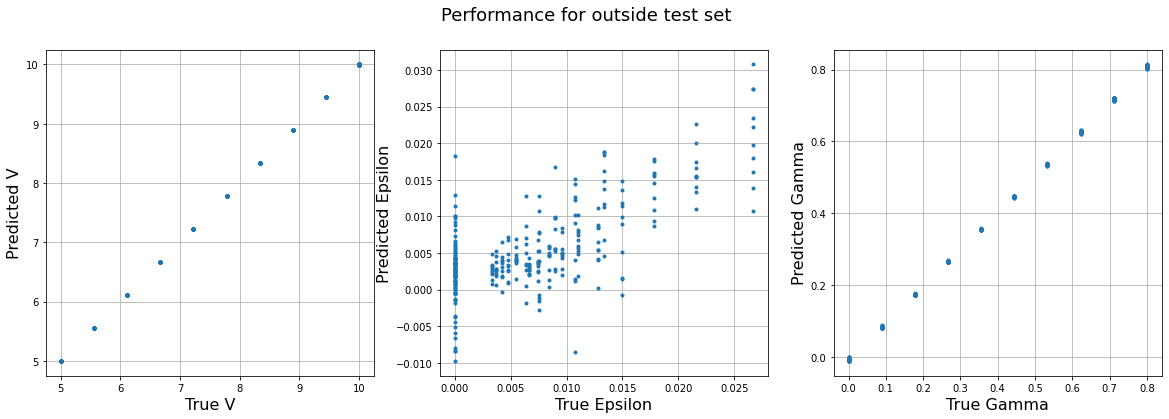

In [ ]:
figure, axis = plt.subplots(1,3,figsize=(20, 6))
figure.suptitle('Performance for outside test set', fontsize=18)
axis[0].plot(np.array(test_all['target_V']), v_res,'.')
axis[0].set_ylabel('Predicted V', fontsize=16)
axis[0].set_xlabel('True V', fontsize=16)
axis[0].grid()

axis[1].plot(np.array(test_all['target_eps']), eps_res,'.')
axis[1].set_ylabel('Predicted Epsilon', fontsize=16)
axis[1].set_xlabel('True Epsilon', fontsize=16)
axis[1].grid()

axis[2].plot(np.array(test_all['target_gamma']), gam_res,'.')
axis[2].set_ylabel('Predicted Gamma', fontsize=16)
axis[2].set_xlabel('True Gamma', fontsize=16)
axis[2].grid()